In [110]:
import numpy as np
import math
import matplotlib.pyplot as plt

# basic functions

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def catTriangle(w,l):
    return int(math.factorial(w+l)*(w+-l+1)/(math.factorial(l)*math.factorial(w+1)))

def catTrapezoid(w,l,m):
    if 0 <= l < m:
        return nCr(w + l, l)
    elif m <= l <= w + m -1:
        return nCr(w+l,l) - nCr(w+l,l-m)
    else:
        return 0

dp = {}
def catTrapezoidWeighted(w,l,m,a,b):
    f = (w,l,m,a,b)
    if f in dp:
        return dp[f]
    if l == 0:
        return 1
    elif b*l >= a*w + m:
        return 0
    elif w == 0:
        return 1
    else:
        val = catTrapezoidWeighted(w-1,l,m,a,b) + catTrapezoidWeighted(w,l-1,m,a,b)
        dp[f] = val
        return dp[f]
    
dp2 = {}
def catTrapezoidWeightedInverse(x,w,l,p,q,c):
    f = (x,w,l,p,q,c)
    if f in dp2:
        return dp2[f]
    if l == 0:
        return 1
    else:
        x_new = x_update(x,w,l,p,q)
        if local_reward(x_new,p,q,c) < 0:
            dp2[f] = 0
            return dp2[f]
        elif w == 0:
            return 1
        else:
            val = catTrapezoidWeightedInverse(x,w-1,l,p,q,c) + catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            dp2[f] = val
            return dp2[f]

def getAB(p,q,x):
    a = math.log(p/q)
    b = math.log((1-q)/(1-p))

    return (a/b).as_integer_ratio()
        
def update_prior(x,p,q,result):
    if result == True:
        return p*x/(win(x,p,q))
    else:
        return (1 - p)*x/(lose(x,p,q))

def prior_inverse(x,p,q,result):
    if result == True:
        return x*q/(p - x*p + x*q)
    else:
        return x*(1-q)/( (1-p) - x*(1-p) + x*(1-q))

def local_reward(x,p,q,c):
    out = win(x,p,q) - c
    return out

def win(x,p,q):
    return x*p + (1-x)*q

def lose(x,p,q):
    return x*(1-p) + (1-x)*(1-q)

def x_update(x,w,l,p,q):
    return  (x*p**w*(1-p)**l)/(x*p**w*(1-p)**l + (1-x)*q**w*(1-q)**l)

def expected_profit(x,p,q,c,c2,delta,rounds=100):
    
    # begin: assume c > c2. and that local_reward(x,p,q) > c
    if c < c2:
        return 0
    
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
#     print(local_reward(x_new,p,q,c))
    while local_reward(x_new,p,q,c) >= 0 and possibleLosses < 40:
        possibleLosses += 1
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
#     print('I can lose', possibleLosses)
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2))
            
        for w in range(lowest,t + 1,1):
            l = t - w
#             print(f"t: {t}, w: {w}, l: {l}, paths: {catTrapezoid(w,l,possibleLosses+1)}")
            add = delta**t*(c - c2)*catTrapezoid(w,l,possibleLosses+1)*prob_reach(x,w,l,p,q)
            tot += add
    return tot

def expected_profit_weighted(x,p,q,c,c2,delta,rounds=100):
    
    # begin: assume c > c2. and that local_reward(x,p,q) > c
    if c < c2:
        return 0
    
    tot = 0

    for t in range(rounds):
        lowest = 0
            
        for w in range(lowest,t + 1,1):
            l = t - w
            print(f"t: {t}, w: {w}, l: {l}, paths: {catTrapezoidWeightedInverse(x,w,l,p,q,c)}")
            print(x,w,l,p,q,c, prob_reach(x,w,l,p,q))
            add = delta**t*(c - c2)*catTrapezoidWeightedInverse(x,w,l,p,q,c)*prob_reach(x,w,l,p,q)
            tot += add
    return tot

def prob_reach(x,w,l,p,q):
    prob = 1
    for i in range(w):
        prob *= win(x,p,q)
        x = update_prior(x,p,q,True)
    for i in range(l):
        prob *= lose(x,p,q)
        x = update_prior(x,p,q,False)
    return prob

def getPossibleCX(x,p,q,c):
    # todo: add c2
    # returns the possible static prices such that local reward > 0
    if local_reward(x,p,q,c) < 0:
        return []
    elif x == 1:
        return []
    else:
        kList = []
        possible = True
        k = 0
        while possible: # todo if c < q then forever
            if local_reward(x,p,q,c) <= 0 or k > 30:
                possible = False
            k += 1
            c2 = win(x,p,q)
            kList.append(c2)
#             print(c2, k)
            x = update_prior(x,p,q,False)
        return kList

In [116]:
x = 0.5
# w = 2
# l = 1
p = 0.6
q = 0.4
c = 0.41
c2 = 0.3
delta = 0.9

# x = update_prior(0.5, 0.7, 0.4, False)
# update_prior(x, 0.7, 0.4, False)

print(expected_profit_weighted(x,0.9,q,c,c2,delta,rounds=4))
print(expected_profit_weighted(x,0.6,q,c,c2,delta,rounds=4))

t: 0, w: 0, l: 0, paths: 1
0.5 0 0 0.9 0.4 0.41 1
t: 1, w: 0, l: 1, paths: 1
0.5 0 1 0.9 0.4 0.41 0.35
t: 1, w: 1, l: 0, paths: 1
0.5 1 0 0.9 0.4 0.41 0.65
t: 2, w: 0, l: 2, paths: 1
0.5 0 2 0.9 0.4 0.41 0.185
t: 2, w: 1, l: 1, paths: 2
0.5 1 1 0.9 0.4 0.41 0.165
t: 2, w: 2, l: 0, paths: 1
0.5 2 0 0.9 0.4 0.41 0.48500000000000004
t: 3, w: 0, l: 3, paths: 0
0.5 0 3 0.9 0.4 0.41 0.1085
t: 3, w: 1, l: 2, paths: 3
0.5 1 2 0.9 0.4 0.41 0.0765
t: 3, w: 2, l: 1, paths: 3
0.5 2 1 0.9 0.4 0.41 0.0885
t: 3, w: 3, l: 0, paths: 1
0.5 3 0 0.9 0.4 0.41 0.3965
0.36958938499999994
t: 0, w: 0, l: 0, paths: 1
0.5 0 0 0.6 0.4 0.41 1
t: 1, w: 0, l: 1, paths: 1
0.5 0 1 0.6 0.4 0.41 0.5
t: 1, w: 1, l: 0, paths: 1
0.5 1 0 0.6 0.4 0.41 0.5
t: 2, w: 0, l: 2, paths: 1
0.5 0 2 0.6 0.4 0.41 0.26
t: 2, w: 1, l: 1, paths: 2
0.5 1 1 0.6 0.4 0.41 0.24
t: 2, w: 2, l: 0, paths: 1
0.5 2 0 0.6 0.4 0.41 0.26
t: 3, w: 0, l: 3, paths: 1
0.5 0 3 0.6 0.4 0.41 0.13999999999999999
t: 3, w: 1, l: 2, paths: 3
0.5 1 2 0.6 0.4 0.41

0.4 0.9999720573339459
0.405 1.0257758463063942
0.41000000000000003 1.0518932140692854
0.41500000000000004 1.0801904683919126
0.42000000000000004 1.0980055352508609
0.42500000000000004 1.0993986054351943
0.43000000000000005 1.1433745496526078
0.43500000000000005 1.1154898389667367
0.44 1.1568042774469973
0.445 1.198118715927248
0.45 1.1156829392214298
0.455 1.1528723705288084
0.46 1.1900618018361933
0.465 1.0081476072005935
0.47000000000000003 1.0386975346915222
0.47500000000000003 1.0692474621824528
0.48000000000000004 0.6991441484009601
0.48500000000000004 0.7185648191898727
0.49 0.7379854899787887
0.495 0.7574061607677031
0.5 0.7768268315566201
0.48 1.099797389673374
0.46153846153846156 1.2015047037769195
0.44571428571428573 1.2040207785672807
0.4329896907216495 1.1696694441331181
0.42327272727272736 1.1279511407577003
0.41614123581336704 1.090910051416132
0.4110583153347732 1.0620135296965025
0.407510635176764 1.0410274900720682
0.40507056202030206 1.0264651874120412
0.403409185490

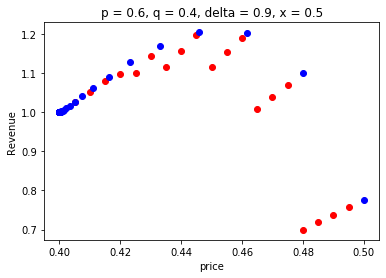

In [126]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.3
delta = 0.9

# plot
# prices = getPossibleCX(x,p,q,c2)
prices = [0.4 + 0.005*i for i in range(20)]
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
    print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')

prices = getPossibleCX(x,p,q,c2)
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
    print(prices[i],ep)
    profits.append(ep)

plt.plot(prices,profits,'bo')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.title('p = 0.6, q = 0.4, delta = 0.9, x = 0.5')
plt.show()

# expected_profit(x,p,q,0.41,c2,delta,10)

0.5 0.7768268315566201
0.48 1.099797389673374
0.46153846153846156 1.2015047037769195
0.44571428571428573 1.2040207785672807
0.4329896907216495 1.1696694441331181
0.42327272727272736 1.1279511407577003
0.41614123581336704 1.090910051416132
0.4110583153347732 1.0620135296965025
0.407510635176764 1.0410274900720682
0.40507056202030206 1.0264651874120412
0.40340918549098603 1.0166784241402258
0.40228577806300403 1.0102608705806677
0.40152967955528757 1.0061394067657914
0.4010223929261193 1.003543967414633
0.40068275869684933 1.0019427699702024
0.400455691009566 1.0009782010346115
0.40030402490874 1.0004144507999448
0.4002027860258317 1.0000985766442188
0.40013523639063814 0.9999327784954489
0.4000901779193193 0.9998554748102639
0.40006012764985677 0.9998284449608719
0.40004008911734523 0.9998284645385034
0.40002672786405763 0.9998416918726705
0.4000178193698279 0.999860198743667
0.4000118799327068 0.9998795938886363
0.4000079201119552 0.9998976843655003
0.40000528014433573 0.99991347771745

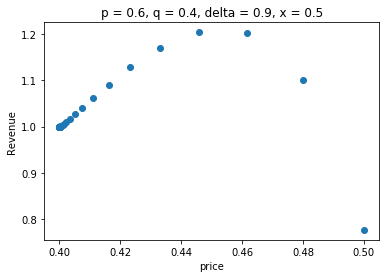

In [123]:
prices = getPossibleCX(x,p,q,c2)
# prices = [0.4 + 0.01*i for i in range(30)]
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
    print(prices[i],ep)
    profits.append(ep)

plt.plot(prices,profits,'o')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.title('p = 0.6, q = 0.4, delta = 0.9, x = 0.5')
plt.show()